In [86]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import pickle
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import parameter_optimization as po
import ast

TF_KALE_tpm = pd.read_csv('../data/validation_data_sets/TF_KALE_merged_log_tpm.csv', index_col = 0)
iM_table = pd.read_csv('../data/precise_1k/iM_table.csv', index_col = 0)
k_to_iM = {index : row['name'] for index, row in iM_table.iterrows()}
A_df = pd.read_csv('../data/precise_1k/A.csv', index_col = 0).rename(index = k_to_iM)
TFK_A_df = pd.read_pickle('../../../Dropbox (UCSD SBRG)/Dalldorf_Files/monthly_code_backup/KALE_on_SCALE/data/TF_KALE_A.pkl')

flags_df = pd.read_csv('../data/saved_flags_expanded_curated.csv', index_col = 0)


# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1k/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

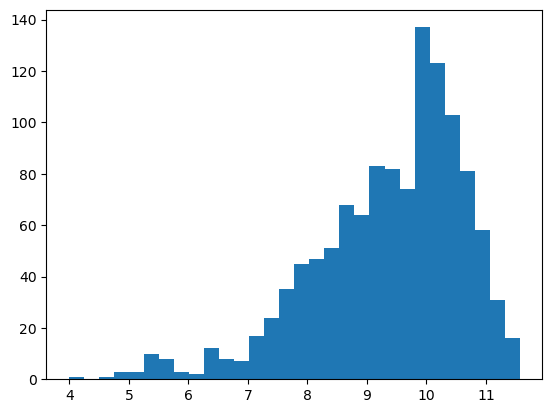

In [9]:
# plot ptsG expression across samples, highlight crp ones
plt.hist(TF_KALE_tpm.loc['b1101'], bins = 30)
plt.show()

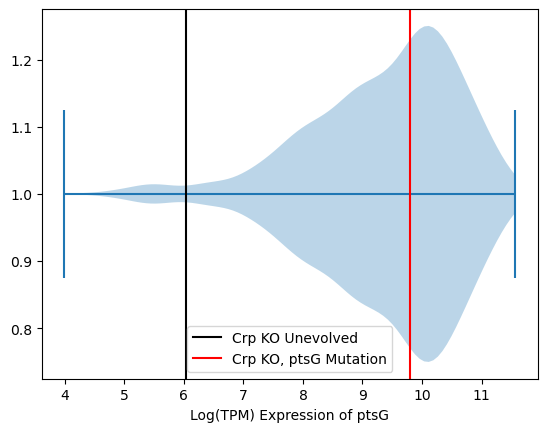

In [24]:
plt.violinplot(TF_KALE_tpm.loc['b1101'], vert = False)
plt.axvline(x = TF_KALE_tpm.loc['b1101']['crp A0 F0 I1 R1'], c = 'k', label = 'Crp KO Unevolved')
plt.axvline(x = TF_KALE_tpm.loc['b1101']['crp A4 F20 I1 R1'], c = 'red', label = 'Crp KO, ptsG Mutation')
plt.legend()
plt.xlabel('Log(TPM) Expression of ptsG')
plt.savefig('../figures/ptsG_expression.pdf', transparent = True)
plt.show()

# predict expression of crp KO samples

In [2]:
# let's pick a similar point to the wildtype from TF KALE (so pick the highest correlated p1k sample to wt a0 f0)
# calculate the gene expression, now try setting cActivator to 0 and recalculate
# can we adjust cInhibitor to restore normal expression?\
log_tpm_df['wt A0 F0 I1 R1'] = TF_KALE_tpm['wt A0 F0 I1 R1']
A_df['wt A0 F0 I1 R1'] = TFK_A_df.T['wt A0 F0 I1 R1']
#tpm_corr_df = log_tpm_df.corr()

# let's also do the resulting metabolite concentration plots
# conversion to metabolite total concentration

# settings
case = 'Crp-2___DhaR'


iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
mRNA_ratio_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
input_mRNA_df = pd.read_csv(GAMs_run_dir+'/input_files/actual_mRNA_ratio.csv', index_col = 0)
overlap = list(set(input_mRNA_df.index).intersection(mRNA_ratio_df.index))
mRNA_ratio_df = mRNA_ratio_df.loc[overlap]
input_mRNA_df = input_mRNA_df.loc[overlap]
err = (mRNA_ratio_df - input_mRNA_df)**2

In [111]:
# let's find teh best sample for us
ct = 0
print('index : Crp-2 Err, DhaR Err, mRNA Err')
for index, val in abs(A_df.loc['Crp-2'] - A_df.loc['Crp-2']['wt A0 F0 I1 R1']).sort_values().items():
    ct += 1
    if ct == 1:
        continue
    print(index, end = ' : ')
    print('{:.4f}'.format(val), end = ', ')
    print('{:.4f}'.format(abs(A_df.loc['DhaR'][index] - A_df.loc['DhaR']['wt A0 F0 I1 R1'])), end = ', ')
    try:
        print('{:.4f}'.format(err.loc[index]['b1101']))
    except:
        print('n/a')

index : Crp-2 Err, DhaR Err, mRNA Err
p1k_00200 : 0.0070, 4.4765, 0.0463
p1k_00005 : 0.0075, 2.7076, 0.0000
p1k_00601 : 0.0149, 2.2950, 0.1018
p1k_00506 : 0.0209, 5.1692, 0.0062
p1k_00815 : 0.0233, 1.8184, 0.1364
p1k_00996 : 0.0264, 3.9543, 0.0018
p1k_00077 : 0.0313, 3.8320, 0.0060
p1k_00877 : 0.0450, 4.0565, 0.0129
p1k_00624 : 0.0472, 1.6748, 0.0047
p1k_00424 : 0.0476, 1.6960, 0.1282
p1k_00423 : 0.0514, 2.2805, 0.0860
p1k_00625 : 0.0677, 1.7624, 0.0038
p1k_00224 : 0.0704, 1.3248, 0.1155
p1k_00316 : 0.0868, 5.1401, 0.1773
p1k_00071 : 0.1003, 3.3037, n/a
p1k_00854 : 0.1009, 6.1849, 0.0006
p1k_00630 : 0.1137, 1.8156, 0.0077
p1k_00223 : 0.1164, 1.0099, 0.1775
p1k_00002 : 0.1180, 2.9801, 0.0002
p1k_00225 : 0.1280, 1.7144, 0.0921
p1k_00920 : 0.1287, 1.9160, 0.0035
p1k_00550 : 0.1391, 4.1211, 0.0554
p1k_00269 : 0.1444, 0.5927, 0.3235
p1k_00297 : 0.1447, 2.8412, 0.0005
p1k_00159 : 0.1461, 3.0925, 0.0063
p1k_00984 : 0.1461, 3.3290, 0.0026
p1k_00211 : 0.1462, 2.3048, 0.0106
p1k_00947 : 0.1555, 

p1k_00859 : 1.5290, 1.8656, 0.0148
p1k_00319 : 1.5347, 2.8759, 0.0074
p1k_00707 : 1.5422, 0.0798, 0.0013
p1k_00820 : 1.5423, 2.5531, 0.0000
p1k_00333 : 1.5491, 3.0873, 0.2339
p1k_00668 : 1.5691, 0.0164, 0.0001
p1k_00732 : 1.5740, 0.3076, 0.0027
p1k_00202 : 1.5742, 1.9871, 0.0352
p1k_00809 : 1.5877, 2.6492, 0.0024
p1k_00344 : 1.5895, 2.0253, 0.1115
p1k_00543 : 1.5979, 2.6804, 0.0898
p1k_00264 : 1.6041, 2.3680, 0.1759
p1k_00016 : 1.6042, 2.2660, 0.0440
p1k_00639 : 1.6137, 0.6760, 0.0047
p1k_00803 : 1.6207, 1.4492, 0.0026
p1k_00616 : 1.6209, 0.5411, 0.0023
p1k_00340 : 1.6321, 1.9132, 0.2860
p1k_00294 : 1.6394, 1.9194, 0.0538
p1k_00149 : 1.6411, 3.3774, 0.0186
p1k_00817 : 1.6418, 2.4437, 0.0006
p1k_00868 : 1.6427, 0.7944, 0.1259
p1k_00736 : 1.6431, 6.5969, 0.0239
p1k_00998 : 1.6501, 2.1420, 0.0000
p1k_00266 : 1.6681, 2.5042, 0.0158
p1k_00141 : 1.6682, 4.4504, 0.0203
p1k_00293 : 1.6695, 1.7585, 0.0840
p1k_00634 : 1.6728, 3.4205, 0.0058
p1k_00656 : 1.6833, 0.8363, 0.0307
p1k_01010 : 1.6850, 

p1k_00901 : 3.4444, 3.7549, 0.0102
p1k_00475 : 3.4666, 3.1114, 0.0002
p1k_00439 : 3.4678, 0.3835, 0.4219
p1k_00131 : 3.4686, 3.3022, 0.0370
p1k_00575 : 3.4695, 4.1305, 0.0495
p1k_00931 : 3.4725, 1.3303, 0.0217
p1k_00476 : 3.4764, 3.7583, 0.0007
p1k_00176 : 3.5096, 0.9285, 0.0394
p1k_00381 : 3.5328, 3.3356, 0.0156
p1k_00175 : 3.5390, 1.2384, 0.0808
p1k_00127 : 3.5557, 0.9003, 0.0023
p1k_00197 : 3.5577, 5.7684, 0.3344
p1k_00345 : 3.5617, 1.6670, 0.1568
p1k_00741 : 3.5916, 2.2247, 0.0160
p1k_00564 : 3.6303, 1.0450, 0.3004
p1k_00241 : 3.6466, 0.0930, 0.0007
p1k_00742 : 3.6534, 2.4560, 0.0155
p1k_00912 : 3.6854, 1.1849, 0.0030
p1k_00451 : 3.6888, 6.6447, 0.1119
p1k_00710 : 3.6891, 2.6094, 0.0759
p1k_00918 : 3.7139, 5.0327, 1.6057
p1k_00916 : 3.7187, 2.5422, 0.0616
p1k_00242 : 3.7195, 0.1201, 0.0008
p1k_00403 : 3.7217, 1.0107, 0.3003
p1k_00687 : 3.7416, 6.8526, 0.0024
p1k_00309 : 3.7479, 6.7135, 0.0269
p1k_00158 : 3.7789, 0.6960, 0.0000
p1k_00452 : 3.7793, 6.8588, 0.1655
p1k_00680 : 3.8023, 

p1k_00967 : 11.2533, 1.2947, 0.0001
p1k_01024 : 11.2974, 1.9047, 0.0319
p1k_00108 : 11.4225, 0.3884, 0.0026
p1k_01038 : 11.4252, 1.9304, 0.0223
p1k_01006 : 11.4439, 2.2491, 0.0105
p1k_00942 : 11.4457, 1.1380, 0.0010
p1k_00949 : 11.4549, 3.6095, 0.0228
p1k_00988 : 11.5391, 1.1923, 0.0018
p1k_01021 : 11.5583, 0.6970, 0.0054
p1k_00976 : 11.5648, 0.8397, 0.0055
p1k_00987 : 11.5797, 1.5455, 0.0066
p1k_00946 : 11.6510, 2.2284, 0.0487
p1k_01000 : 11.6575, 1.5857, 0.0005
p1k_00109 : 11.6617, 0.5428, 0.0009
p1k_01034 : 11.6839, 1.2301, 0.0070
p1k_00944 : 11.7199, 1.4554, 0.0192
p1k_01023 : 11.7236, 0.9342, 0.0039
p1k_00970 : 11.7695, 1.2400, 0.0176
p1k_00943 : 11.8191, 2.1672, 0.0200
p1k_00964 : 11.8696, 1.1001, 0.0021
p1k_00992 : 11.8720, 1.1432, 0.0065
p1k_00384 : 11.8818, 0.4904, 0.0733
p1k_01015 : 11.9197, 1.6426, 0.0040
p1k_00994 : 11.9472, 1.6303, 0.0197
p1k_00585 : 11.9579, 1.0420, 0.0148
p1k_01043 : 11.9582, 2.0222, 0.0213
p1k_01054 : 11.9767, 1.5677, 0.0118
p1k_01037 : 12.0264, 1.9374,

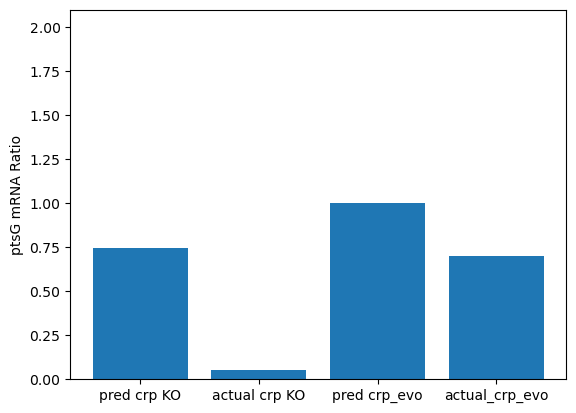

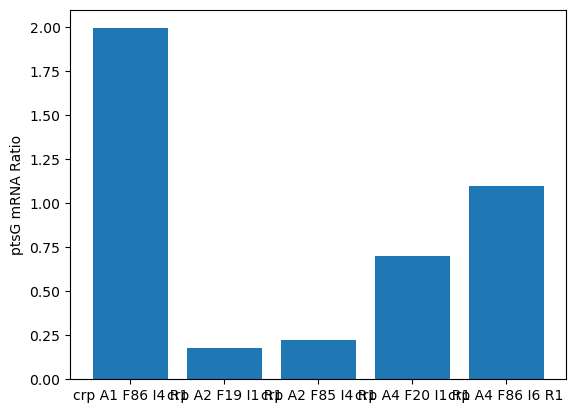

In [117]:
# p1k_00411 has very little difference, let's grab its relevant results
center = 'p1k_00411'
cAct = GAMS_calc_cAct.loc[center]['b1101']
cInh = GAMS_calc_cInh.loc[center]['b1101']

# constants
basal_conds = ast.literal_eval(flags_df.loc['b1101']['basal_conditions'])
KdRNAPCrp = pd.read_csv(GAMs_run_dir+'/input_files/grid_constants.csv', index_col = 0).loc['KdRNAPCrp']['b1101']
KdRNAP = pd.read_csv(GAMs_run_dir+'/input_files/grid_constants.csv', index_col = 0).loc['KdRNAP']['b1101']
KeqOpening = pd.read_csv(GAMs_run_dir+'/input_files/grid_constants.csv', index_col = 0).loc['KeqOpening']['b1101']
RNAP = pd.read_csv(GAMs_run_dir+'/input_files/sample_constants.csv')[center].values[0]
eq = 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))'
lambda_df = po.create_lambdas(equation = eq, constants = {'KdRNAPCrp' : KdRNAPCrp, 'KdRNAP' : KdRNAP, 'RNAP' : RNAP, 'KeqOpening' : KeqOpening})

# values creation
center_val = po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp, lambda_df)
crp_KO_val = po.cActivator_cInhibitor_to_mRNA(0, cInh, KdRNAPCrp, lambda_df)
actual_crp_KO_val = 2**TF_KALE_tpm['crp A0 F0 I1 R1'].loc['b1101'] / 2**log_tpm_df[basal_conds].loc['b1101'].mean()

crp_samples = ['crp A1 F86 I4 R1', 
'crp A2 F19 I1 R1', 
'crp A2 F85 I4 R1', 
'crp A4 F20 I1 R1', 
'crp A4 F86 I6 R1']
samp_to_val = {}
crp_evo_val = po.cActivator_cInhibitor_to_mRNA(0, 0, KdRNAPCrp, lambda_df)
actual_evo_crp_KO_val = 2**TF_KALE_tpm['crp A4 F20 I1 R1'].loc['b1101'] / 2**log_tpm_df[basal_conds].loc['b1101'].mean()

# plot
plt.bar(x = ['pred crp KO', 'actual crp KO', 'pred crp_evo', 'actual_crp_evo'], height = [crp_KO_val, actual_crp_KO_val, crp_evo_val, actual_evo_crp_KO_val])
plt.ylabel('ptsG mRNA Ratio')
plt.ylim([0, 2.1])
plt.savefig('../figures/crp_pred.pdf', transparent = True)
plt.show()
plt.bar(crp_samples, height = [2**TF_KALE_tpm[samp].loc['b1101'] / 2**log_tpm_df[basal_conds].loc['b1101'].mean() for samp in crp_samples])
plt.ylabel('ptsG mRNA Ratio')
plt.ylim([0, 2.1])
plt.savefig('../figures/crp_evos.pdf', transparent = True)
plt.show()

In [99]:
evo_crp_KO_val

1.9978566121805088

In [102]:
crp_evo_val

0.9999999999999954

In [76]:
for col in TF_KALE_tpm.columns:
    if 'crp' in col:
        print(col)

crp A0 F0 I1 R1
crp A1 F19 I1 R1
crp A1 F86 I0 R1
crp A1 F86 I4 R1
crp A2 F19 I1 R1
crp A2 F85 I0 R1
crp A2 F85 I4 R1
crp A4 F20 I1 R1
crp A4 F86 I0 R1
crp A4 F86 I6 R1


# compare predicted cActivator activity compared to glucose source across P1K

In [7]:
# first, create the dataframes



# load in necessary files
base_TF_flags_df = pd.read_csv('../data/TF_flags_expanded.csv', index_col = 0)
pickle_in = open('../data/gene_to_operon_to_motif_scores_dist_to_TSS.pkl', 'rb')
gene_to_operon_to_motif_scores = pickle.load(pickle_in)
pickle_in.close()
pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}
gene_to_b.update({
    'yhbC' : 'b3170',
    #'sroD' : '', # not a real gene
})


case = 'Crp-2___DhaR'

# parse down TF_flags
TF_flags_df = base_TF_flags_df.loc[['Crp-2', 'DhaR']]

# let's find our run_dir
iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f


mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)


In [12]:
act_metab_df[act_metab_df.iM == 'Crp-2']

,iM,Val
sample,,
p1k_00672,Crp-2,3.800000e-14
p1k_00560,Crp-2,8.122865e-01
p1k_00618,Crp-2,3.004414e+01
p1k_00820,Crp-2,8.584561e-01
p1k_00483,Crp-2,9.031320e+01
...,...,...
p1k_00050,Crp-2,3.449837e-01
p1k_00762,Crp-2,5.354429e+01
p1k_00054,Crp-2,4.239156e+00


114
474


TypeError: object of type 'int' has no len()

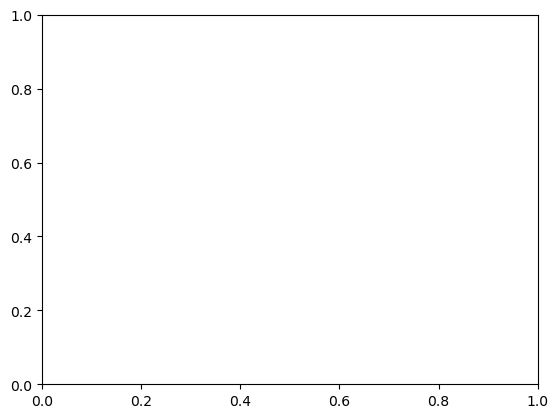

In [60]:
sample_table = pd.read_csv('../data/precise_1k/sample_table.csv', index_col = 0)
keep = []
for index, row in sample_table.iterrows():
    if str(row['Carbon Source (g/L)']) in ['glucose(4)', 'glucose(2)']:
        keep.append(index)
overlap = list(set(keep).intersection(act_metab_df.index))
gluc_metab_df = pd.DataFrame(index = overlap)
gluc_metab_df['metab_pred'] = act_metab_df[act_metab_df.iM == 'Crp-2'].loc[overlap]['Val']
gluc_metab_df['glucose'] = sample_table.loc[overlap]['Carbon Source (g/L)']

datas = []
labels = []
for glucose in ['glucose(2)', 'glucose(4)']:
    bby = gluc_metab_df.loc[gluc_metab_df.glucose == glucose]
    datas.append(bby['metab_pred'].values)
    labels.append(glucose)
    print(len(bby))
plt.boxplot([data for data in datas], labels = labels)
plt.show()

In [50]:
np.log10(datas[0])

array([ -6.86947776,  -0.42546966, -11.52404886, -13.4202164 ,
       -13.41590443, -13.4202164 , -11.65240076, -13.4202164 ,
         0.1304691 , -13.4202164 ,  -7.59657237, -13.2571931 ,
         0.08395432, -13.4202164 , -13.4202164 , -13.4202164 ,
       -10.94015252,   0.11695516, -10.13924313, -13.4139707 ,
        -0.18251169,   1.20721351, -11.56392025,  -9.91633352,
         1.1029671 ,   0.28677077, -13.4202164 , -13.38002211,
       -13.4202164 ,   1.45295014,  -0.47368587, -13.37056189,
       -13.4202164 , -13.37510978, -13.4202164 ,  -0.45385686,
       -13.41293372,  -0.28777731, -13.4202164 , -13.4202164 ,
         1.3740762 ,  -0.79455003, -13.35601634,  -0.39493841,
       -13.4202164 ,  -0.18122949, -13.29971579, -13.4202164 ,
         0.29222299,  -0.31327498, -13.4202164 , -13.4202164 ,
         1.38138173,   1.75301749, -13.4202164 , -10.50457734,
       -13.37293943, -13.32315653,  -0.49528804, -13.4202164 ,
       -13.4202164 ,   1.62362877, -11.7709924 ,  -0.73

114
474


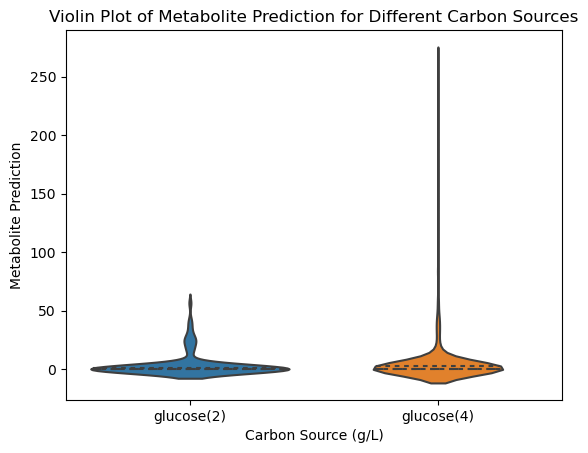

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
sample_table = pd.read_csv('../data/precise_1k/sample_table.csv', index_col=0)

# Filter rows based on condition
keep = []
for index, row in sample_table.iterrows():
    if str(row['Carbon Source (g/L)']) in ['glucose(4)', 'glucose(2)']:
        keep.append(index)
overlap = list(set(keep).intersection(act_metab_df.index))
gluc_metab_df = pd.DataFrame(index=overlap)
gluc_metab_df['metab_pred'] = act_metab_df[act_metab_df.iM == 'Crp-2'].loc[overlap]['Val']
gluc_metab_df['glucose'] = sample_table.loc[overlap]['Carbon Source (g/L)']

# Prepare data for violin plots
datas = []
labels = []
for glucose in ['glucose(2)', 'glucose(4)']:
    bby = gluc_metab_df.loc[gluc_metab_df.glucose == glucose]
    datas.append(bby['metab_pred'].values)
    labels.append(glucose)
    print(len(bby))

# Create violin plots
sns.violinplot(data=datas, inner="quartile")
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.xlabel('Carbon Source (g/L)')
plt.ylabel('Metabolite Prediction')
plt.title('Violin Plot of Metabolite Prediction for Different Carbon Sources')
plt.show()


In [17]:
sample_table

,sample_id,study,project,condition,rep_id,Strain Description,Strain,Culture Type,Evolved Sample,Base Media,...,creator,passed_fastqc,passed_pct_reads_mapped,passed_reads_mapped_to_CDS,passed_global_correlation,full_name,passed_similar_replicates,passed_number_replicates,run_date,n_replicates
p1k_00001,control__wt_glc__1,Control,control,wt_glc,1,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,Sangwoo Seo,True,True,True,True,control:wt_glc,True,True,4/17/2013,2
p1k_00002,control__wt_glc__2,Control,control,wt_glc,2,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,Sangwoo Seo,True,True,True,True,control:wt_glc,True,True,4/17/2013,2
p1k_00003,fur__wt_dpd__1,Fur,fur,wt_dpd,1,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,Sangwoo Seo,True,True,True,True,fur:wt_dpd,True,True,10/2/2013,2
p1k_00004,fur__wt_dpd__2,Fur,fur,wt_dpd,2,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,Sangwoo Seo,True,True,True,True,fur:wt_dpd,True,True,10/2/2013,2
p1k_00005,fur__wt_fe__1,Fur,fur,wt_fe,1,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,Sangwoo Seo,True,True,True,True,fur:wt_fe,True,True,9/5/2013,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p1k_01051,DDB3__PD-006_del-rpoS_Fed-batch_15h__2,DDB3,DDB3,PD-006_del-rpoS_Fed-batch_15h,2,Escherichia coli BW25113 del_rpoS,BW25113,Fed-batch,No,Medium C,...,Suresh Sudarsan,True,True,True,True,DDB3:PD-006_del-rpoS_Fed-batch_15h,True,True,10/1/2020,2
p1k_01052,DDB3__PD-009_del-tnaA_Batch_6h__1,DDB3,DDB3,PD-009_del-tnaA_Batch_6h,1,Escherichia coli BW25113 del_tnaA,BW25113,Batch,No,Medium C,...,Suresh Sudarsan,True,True,True,True,DDB3:PD-009_del-tnaA_Batch_6h,True,False,10/1/2020,1
p1k_01053,DDB3__PD-009_del-tnaA_Fed-batch_6h__1,DDB3,DDB3,PD-009_del-tnaA_Fed-batch_6h,1,Escherichia coli BW25113 del_tnaA,BW25113,Fed-batch,No,Medium C,...,Suresh Sudarsan,True,True,True,True,DDB3:PD-009_del-tnaA_Fed-batch_6h,True,False,10/1/2020,1
p1k_01054,DDB3__PD-009_del-tnaA_Fed-batch_15h__1,DDB3,DDB3,PD-009_del-tnaA_Fed-batch_15h,1,Escherichia coli BW25113 del_tnaA,BW25113,Fed-batch,No,Medium C,...,Suresh Sudarsan,True,True,True,True,DDB3:PD-009_del-tnaA_Fed-batch_15h,True,True,10/1/2020,2
